## LIB

In [ ]:
!pip install yahoo_fin
import yahoo_fin.stock_info as si

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, LSTM
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report,multilabel_confusion_matrix, plot_confusion_matrix, accuracy_score
from tensorflow import keras
from datetime import datetime, timedelta
from sklearn.preprocessing import OneHotEncoder

# MAIN DATA

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
df = pd.read_excel("/content/drive/MyDrive/StockML/sample_data.xlsx", sheet_name = "Sheet1")

In [6]:
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

In [7]:
df['MONTH'] = df['date'] .dt.month

MAX30, MIN30, MEAN7, and STD7 used can improve the model accuracy, based on experimentation.

In [8]:
df['MAX30'] = df[['H-30', 'H-29', 'H-28', 'H-27', 'H-26', 'H-25',
       'H-24', 'H-23', 'H-22', 'H-21', 'H-20', 'H-19', 'H-18', 'H-17', 'H-16',
       'H-15', 'H-14', 'H-13', 'H-12', 'H-11', 'H-10', 'H-9', 'H-8', 'H-7',
       'H-6', 'H-5', 'H-4', 'H-3', 'H-2', 'H-1']].max(axis=1)

In [9]:
df['MIN30'] = df[['H-30', 'H-29', 'H-28', 'H-27', 'H-26', 'H-25',
       'H-24', 'H-23', 'H-22', 'H-21', 'H-20', 'H-19', 'H-18', 'H-17', 'H-16',
       'H-15', 'H-14', 'H-13', 'H-12', 'H-11', 'H-10', 'H-9', 'H-8', 'H-7',
       'H-6', 'H-5', 'H-4', 'H-3', 'H-2', 'H-1']].min(axis=1)

In [10]:
df['MEAN7'] = df[['H-7', 'H-6', 'H-5', 'H-4', 'H-3', 'H-2', 'H-1']].mean(axis=1)

In [11]:
df['STD7'] = df[['H-7', 'H-6', 'H-5', 'H-4', 'H-3', 'H-2', 'H-1']].std(axis=1)

The label consist of BUY, SELL, and NOTHING. NOTHING means its either buy or sell signal.

In [12]:
df["BUY"].sum()

1587

In [13]:
df["SELL"].sum()

2564

In [14]:
df["NOTHING"].sum()

5848

In [15]:
df.shape

(9999, 41)

In [16]:
df.head()

,code,date,H-31,H-30,H-29,H-28,H-27,H-26,H-25,H-24,H-23,H-22,H-21,H-20,H-19,H-18,H-17,H-16,H-15,H-14,H-13,H-12,H-11,H-10,H-9,H-8,H-7,H-6,H-5,H-4,H-3,H-2,H-1,BUY,SELL,NOTHING,MONTH,MAX30,MIN30,MEAN7,STD7
0,INCO.JK,2021-12-30,0,0.02542,0.00620,0.00205,-0.00205,0.01232,-0.03245,-0.00419,0.00842,-0.02088,0.02132,-0.00626,-0.00210,0.00632,-0.00837,0.01266,-0.00625,-0.01258,0.00000,-0.01274,-0.00860,0.01085,-0.00858,0.00000,-0.02381,0.00443,0.03532,0.00000,0.00426,-0.01274,0.00645,0,0,1,12,0.03532,-0.03245,0.001987,0.018387
1,WOMF.JK,2021-12-30,0,0.00000,0.00000,-0.00840,0.02542,-0.01653,0.00000,-0.01681,0.00000,0.00000,0.00000,0.01709,-0.01681,0.00000,0.01709,0.00000,0.02521,0.01639,-0.00806,0.02439,-0.02381,-0.01626,-0.00826,-0.00833,0.00840,0.00000,0.01667,0.02459,-0.03200,0.00000,0.01653,0,0,1,12,0.02542,-0.03200,0.004884,0.018634
2,PWON.JK,2020-03-12,0,-0.01835,-0.02804,-0.01923,0.02941,0.00000,0.01905,0.00000,-0.00935,0.00943,0.00000,0.00935,0.02778,0.03604,0.04348,-0.00833,-0.02521,-0.00862,-0.06087,0.02778,-0.00901,-0.01818,-0.01852,-0.00943,0.03810,0.02752,-0.02679,-0.02752,-0.05660,-0.00400,-0.09639,1,0,0,3,0.04348,-0.09639,-0.020811,0.046838
3,PWON.JK,2020-03-17,0,0.02941,0.00000,0.01905,0.00000,-0.00935,0.00943,0.00000,0.00935,0.02778,0.03604,0.04348,-0.00833,-0.02521,-0.00862,-0.06087,0.02778,-0.00901,-0.01818,-0.01852,-0.00943,0.03810,0.02752,-0.02679,-0.02752,-0.05660,-0.00400,-0.09639,-0.08444,0.00000,0.00000,1,0,0,3,0.04348,-0.09639,-0.038421,0.040957
4,PWON.JK,2020-03-18,0,0.00000,0.01905,0.00000,-0.00935,0.00943,0.00000,0.00935,0.02778,0.03604,0.04348,-0.00833,-0.02521,-0.00862,-0.06087,0.02778,-0.00901,-0.01818,-0.01852,-0.00943,0.03810,0.02752,-0.02679,-0.02752,-0.05660,-0.00400,-0.09639,-0.08444,0.00000,0.00000,-0.16505,1,0,0,3,0.04348,-0.16505,-0.058069,0.062288


# SECTOR DATA

In [18]:
df_sector = pd.read_excel("/content/drive/MyDrive/StockML/sector_detail.xlsx")
col_name = df_sector['sector'].unique().copy()
col_name.sort()

In [19]:
# col_name

In [20]:
enc = OneHotEncoder()
enc.fit(df_sector[['sector']])
df_encode_sector = enc.transform(df_sector[['sector']]).toarray()
df_encode_sector = pd.DataFrame(df_encode_sector, columns=col_name)
df_sector = df_sector.drop(['sector','industry'],axis=1)
df_sector = pd.concat([df_sector, df_encode_sector], axis=1, ignore_index=True)
df_sector.columns = ['code']+col_name.tolist()

In [21]:
df_sector.shape

(87, 12)

In [22]:
df = pd.merge(df, df_sector, how="left", on=["code"])

In [23]:
df.shape

(9999, 52)

# DF FINAL

Drop the code, date, and H-31 column because we didn't need it.

In [24]:
df = df.drop(["code","date","H-31"], axis = 1)

In [25]:
df = df.dropna(axis = 0)

In [26]:
df.head()

,H-30,H-29,H-28,H-27,H-26,H-25,H-24,H-23,H-22,H-21,H-20,H-19,H-18,H-17,H-16,H-15,H-14,H-13,H-12,H-11,H-10,H-9,H-8,H-7,H-6,H-5,H-4,H-3,H-2,H-1,BUY,SELL,NOTHING,MONTH,MAX30,MIN30,MEAN7,STD7,Basic Materials,Communication Services,Consumer Cyclical,Consumer Defensive,Energy,Financial Services,Healthcare,Industrials,Real Estate,Technology,Utilities
0,0.02542,0.00620,0.00205,-0.00205,0.01232,-0.03245,-0.00419,0.00842,-0.02088,0.02132,-0.00626,-0.00210,0.00632,-0.00837,0.01266,-0.00625,-0.01258,0.00000,-0.01274,-0.00860,0.01085,-0.00858,0.00000,-0.02381,0.00443,0.03532,0.00000,0.00426,-0.01274,0.00645,0,0,1,12,0.03532,-0.03245,0.001987,0.018387,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.00000,0.00000,-0.00840,0.02542,-0.01653,0.00000,-0.01681,0.00000,0.00000,0.00000,0.01709,-0.01681,0.00000,0.01709,0.00000,0.02521,0.01639,-0.00806,0.02439,-0.02381,-0.01626,-0.00826,-0.00833,0.00840,0.00000,0.01667,0.02459,-0.03200,0.00000,0.01653,0,0,1,12,0.02542,-0.03200,0.004884,0.018634,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,-0.01835,-0.02804,-0.01923,0.02941,0.00000,0.01905,0.00000,-0.00935,0.00943,0.00000,0.00935,0.02778,0.03604,0.04348,-0.00833,-0.02521,-0.00862,-0.06087,0.02778,-0.00901,-0.01818,-0.01852,-0.00943,0.03810,0.02752,-0.02679,-0.02752,-0.05660,-0.00400,-0.09639,1,0,0,3,0.04348,-0.09639,-0.020811,0.046838,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.02941,0.00000,0.01905,0.00000,-0.00935,0.00943,0.00000,0.00935,0.02778,0.03604,0.04348,-0.00833,-0.02521,-0.00862,-0.06087,0.02778,-0.00901,-0.01818,-0.01852,-0.00943,0.03810,0.02752,-0.02679,-0.02752,-0.05660,-0.00400,-0.09639,-0.08444,0.00000,0.00000,1,0,0,3,0.04348,-0.09639,-0.038421,0.040957,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.00000,0.01905,0.00000,-0.00935,0.00943,0.00000,0.00935,0.02778,0.03604,0.04348,-0.00833,-0.02521,-0.00862,-0.06087,0.02778,-0.00901,-0.01818,-0.01852,-0.00943,0.03810,0.02752,-0.02679,-0.02752,-0.05660,-0.00400,-0.09639,-0.08444,0.00000,0.00000,-0.16505,1,0,0,3,0.04348,-0.16505,-0.058069,0.062288,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


# VISUALIZATION

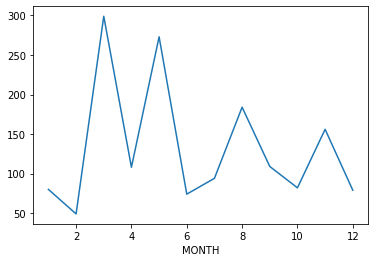

In [27]:
df[df["BUY"]==1].groupby("MONTH").count()["BUY"].plot()

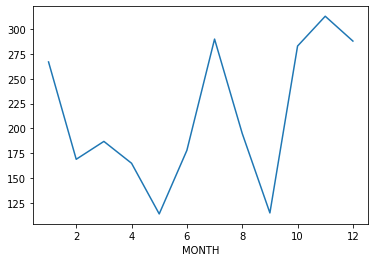

In [28]:
df[df["SELL"]==1].groupby("MONTH").count()["SELL"].plot()

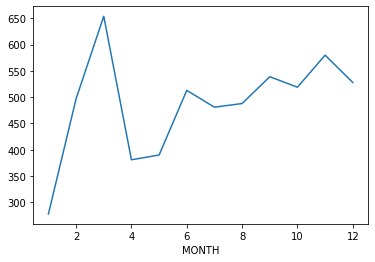

In [29]:
df[df["NOTHING"]==1].groupby("MONTH").count()["BUY"].plot()

# DATA PREPARATION

In [30]:
X = df.drop(['BUY','SELL','NOTHING'],axis=1).values
y = df[['BUY','SELL','NOTHING']].values

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.20,random_state=333)

In [32]:
X_train.shape

(7999, 46)

# MODEL

Not sure why using GELU activation, but it seems better than ReLU. Need more research for this. Some source that might be interesting: https://paperswithcode.com/method/gelu https://medium.com/@shoray.goel/gelu-gaussian-error-linear-unit-4ec59fb2e47c

In [33]:
ann_model = Sequential()

ann_model.add(Dense(units=46,activation='gelu'))
ann_model.add(Dropout(0.1))
ann_model.add(Dense(units=23,activation='gelu'))
ann_model.add(Dropout(0.2))
ann_model.add(Dense(units=11,activation='gelu'))
ann_model.add(Dropout(0.3))
ann_model.add(Dense(units=3,activation='softmax'))

model = Sequential([ann_model])
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate = 0.001))

# TRAIN MODEL

Look here for detail about EarlyStopping https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping

In [34]:
epochs = 200
# batch_size = 50
batch_size = int(X_train.shape[0]/100)
early_stop = EarlyStopping(monitor='val_loss',patience=10)

In [35]:
model.fit(x=X_train, 
          y=y_train, 
          epochs=epochs,
          batch_size=batch_size,
          validation_data=(X_test, y_test) ,
          verbose=1 ,
          callbacks=[early_stop]
          )

Epoch 1/200
102/102 [==============================] - 2s 5ms/step - loss: 0.6160 - val_loss: 0.5749
Epoch 2/200
102/102 [==============================] - 0s 3ms/step - loss: 0.5799 - val_loss: 0.5624
Epoch 3/200
102/102 [==============================] - 0s 3ms/step - loss: 0.5740 - val_loss: 0.5610
Epoch 4/200
102/102 [==============================] - 0s 3ms/step - loss: 0.5708 - val_loss: 0.5573
Epoch 5/200
102/102 [==============================] - 0s 3ms/step - loss: 0.5679 - val_loss: 0.5539
Epoch 6/200
102/102 [==============================] - 0s 3ms/step - loss: 0.5602 - val_loss: 0.5411
Epoch 7/200
102/102 [==============================] - 0s 3ms/step - loss: 0.5419 - val_loss: 0.5028
Epoch 8/200
102/102 [==============================] - 0s 3ms/step - loss: 0.5024 - val_loss: 0.4434
Epoch 9/200
102/102 [==============================] - 0s 3ms/step - loss: 0.4609 - val_loss: 0.4042
Epoch 10/200
102/102 [==============================] - 0s 3ms/step - loss: 0.4361 - val_lo

# MODEL EVALUATION

In [36]:
model_loss = pd.DataFrame(model.history.history)

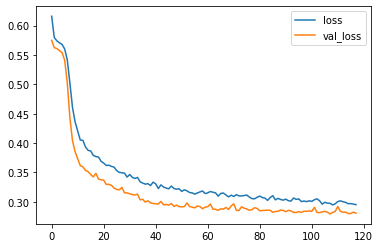

In [37]:
model_loss.plot()

In [38]:
predictions = (model.predict(X_test) > 0.5).astype("int32")

In [39]:
predictions2 = (model.predict(X_train) > 0.5).astype("int32")

In [40]:
accuracy_score(y_train,predictions2)

0.8338542317789723

In [41]:
accuracy_score(y_test,predictions)

0.817

In [42]:
print(classification_report(y_train,predictions2))

              precision    recall  f1-score   support

           0       0.80      0.76      0.78      1262
           1       0.85      0.74      0.79      2078
           2       0.84      0.89      0.86      4659

   micro avg       0.83      0.83      0.83      7999
   macro avg       0.83      0.80      0.81      7999
weighted avg       0.83      0.83      0.83      7999
 samples avg       0.83      0.83      0.83      7999



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [43]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.76      0.71      0.74       325
           1       0.85      0.71      0.77       486
           2       0.82      0.89      0.85      1189

   micro avg       0.82      0.82      0.82      2000
   macro avg       0.81      0.77      0.79      2000
weighted avg       0.82      0.82      0.82      2000
 samples avg       0.82      0.82      0.82      2000



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [44]:
print(df[df["BUY"]==1].shape[0]*0.2)
print(df[df["SELL"]==1].shape[0]*0.2)
print(df[df["NOTHING"]==1].shape[0]*0.2)

317.40000000000003
512.8000000000001
1169.6000000000001


In [45]:
# TN FP
# FN TP

In [46]:
print(multilabel_confusion_matrix(y_test,predictions))

[[[1602   73]
  [  93  232]]

 [[1453   61]
  [ 140  346]]

 [[ 580  231]
  [ 133 1056]]]


# TRAIN WITH ALL DATA

In [47]:
# model.fit(x=X, 
#           y=y, 
#           epochs=80,
#           batch_size=batch_size,
#           validation_data=(X_test, y_test) ,
#           verbose=1 ,
#           callbacks=[early_stop]
#           )

# SAVE

In [48]:
from tensorflow.keras.models import save_model 

In [49]:
save_model(model,"/content/drive/MyDrive/StockML/stockml2", save_format = "h5")

In [50]:
model.save_weights('/content/drive/MyDrive/StockML/stockml_ckpt2')

# LOAD

In [51]:
from tensorflow.keras.models import load_model

In [52]:
model = load_model("/content/drive/MyDrive/StockML/stockml2")

In [53]:
model.load_weights('/content/drive/MyDrive/StockML/stockml_ckpt2')

In [54]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 3)                 3543      
                                                                 
Total params: 3,543
Trainable params: 3,543
Non-trainable params: 0
_________________________________________________________________


# BATCH PREDICT

In [55]:
companies = ["BULL.JK", "BUKK.JK", "PTBA.JK", "SIDO.JK", "EAST.JK", "GGRP.JK", "PTRO.JK", "SILO.JK", 
             "INOV.JK", "BKSL.JK", "CFIN.JK", "PRIM.JK", "BBCA.JK","ADMF.JK", "BTPS.JK", "HRME.JK",
             "EPMT.JK", "ASII.JK"]
today = datetime.now().date()

def get_sector(stock_code):
  return df_sector[df_sector['code']==stock_code].drop("code",axis=1).values.tolist()[0]
  
for company in companies:
  try:
    df2 = si.get_data(company , start_date = today-timedelta(days = 50) , end_date = today)
    df2 = df2.reset_index()
    df2=df2.rename(columns = {'index':'Date'})

    df3 = df2[["Date","adjclose"]].iloc[-30:]
    x = df3["adjclose"].values
    y = []
    for i,j in enumerate(x):
      if i == 0:
          y.append(0)
      else:
          y.append((j-x[i-1])/x[i-1])

    # avg30 = sum(y)/len(y)
    max30 = max(y)
    min30 = min(y)
    mean7 = sum(y[-7:])/len(y[-7:])
    std7 = np.std(y[-7:])
    y.append(pd.to_datetime(today, format='%Y-%m-%d').month)
    # y.append(pd.to_datetime(today, format='%Y-%m-%d').quarter)
    # y.append(avg30)
    y.append(max30)
    y.append(min30)
    y.append(mean7)
    y.append(std7)
    for i in get_sector(company):
      y.append(i)
    sample = np.array(y)
    sample = np.reshape(sample, (1,46))
    predictions = (model.predict(sample) > 0.5).astype("int32")
    print(company, ": ", predictions)
  except Exception as e:
    print(e)
    print("failed to get data for ", company)

BULL.JK :  [[0 0 1]]
BUKK.JK :  [[0 0 1]]
PTBA.JK :  [[0 0 1]]
SIDO.JK :  [[0 0 1]]
EAST.JK :  [[0 1 0]]
GGRP.JK :  [[0 0 1]]
PTRO.JK :  [[0 0 1]]
SILO.JK :  [[0 0 1]]
INOV.JK :  [[0 0 1]]
BKSL.JK :  [[0 1 0]]
CFIN.JK :  [[0 1 0]]
PRIM.JK :  [[0 0 1]]
BBCA.JK :  [[0 0 1]]
ADMF.JK :  [[0 1 0]]
BTPS.JK :  [[0 1 0]]
HRME.JK :  [[0 0 1]]
EPMT.JK :  [[0 0 1]]
ASII.JK :  [[0 0 1]]


In [56]:
# Get one point of data
today = datetime.now().date()
company = "INCO.JK"
df2 = si.get_data(company , start_date = today-timedelta(days = 50) , end_date = today)
df2 = df2.reset_index()
df2=df2.rename(columns = {'index':'Date'})

df3 = df2[["Date","adjclose"]].iloc[-31:]
x = df3["adjclose"].values
y = []
for i,j in enumerate(x):
  if i == 0:
      y.append(0)
  else:
      y.append(round((j-x[i-1])/x[i-1], 5))
print(company)
print(df3.tail(1)['Date'])
y

INCO.JK
33   2022-02-10
Name: Date, dtype: datetime64[ns]


[0,
 -0.01274,
 0.00645,
 0.01709,
 -0.02311,
 -0.0086,
 -0.01085,
 -0.01096,
 0.0,
 -0.05765,
 0.03059,
 0.08676,
 0.0021,
 -0.02306,
 0.01288,
 0.03602,
 0.02249,
 0.005,
 -0.00697,
 -0.02806,
 -0.00412,
 -0.01863,
 -0.00844,
 0.00213,
 0.00425,
 -0.00634,
 0.00638,
 -0.00423,
 -0.01274,
 0.00215,
 0.03004]